在 LangGraph 中，节点（Node）通常通过返回一个字典来更新状态（State）。但在某些场景下，我们不仅想更新数据，还想直接控制图的执行流程——这时就需要 Command，通过从节点函数中返回一个 Command 对象，能够将控制流（边）与状态更新（节点）结合起来。

> 当你在节点函数中返回 Command 时，必须添加返回类型注解，明确指定该节点可能路由到的目标节点名称列表，例如 Command[Literal["other_node1", "other_node2"]]。
这一类型注解对于图的可视化渲染是必需的，同时也告知 LangGraph：当前节点可以跳转到other_node1和other_node2。

# Command参数介绍

In [ ]:
from langgraph.types import Command

Command(
            update={"customer_id": user_input['customer_id']},
            goto="lookup_customer_history"
        )

| 参数 | 类型 | 默认值 | 说明 |
|------|------|--------|------|
| graph | str \| None | None | 要发送命令的图。支持 None（当前图）或 Command.PARENT（最近的父图）|
| update | Any \| None | None | 应用于图状态的更新 |
| resume | dict[str, Any] \| Any \| None | None | 用于恢复执行的值，与 interrupt() 一起使用。可以是中断 ID 到恢复值的映射，或单个值 |
| goto | Send \| Sequence[Send \| N] \| N | () | 下一步导航到的节点。可以是节点名、节点名序列、Send 对象或 Send 对象序列 |

# 同时更新状态和路由节点

利用update参数和goto参数配合实现这个场景。

In [ ]:
def my_node(state: State) -> Command[Literal["my_other_node"]]:
    return Command(
        # 状态更新
        update={"foo": "bar"},
        # 控制流
        goto="my_other_node"
    )

什么时候应该使用 Command 而不是条件边（conditional edges）？
- 使用 Command：当你需要同时更新图的状态（state）并路由到另一个节点时。

例如，在实现多智能体（multi-agent）交接场景中，你不仅需要将控制权交给另一个智能体，还需要向其传递特定信息（即更新状态），这时 Command 是更合适的选择。
- 使用条件边（conditional edges）：当你仅需根据条件决定下一步跳转到哪个节点，而不需要在跳转的同时修改状态时。条件边适用于纯粹的控制流分支，状态更新由目标节点自身完成。

简而言之：

✅ 用 Command —— 状态更新 + 路由 同时发生；

✅ 用条件边 —— 仅做路由，状态保持不变。

In [24]:
from langgraph.graph import StateGraph, END
from langgraph.types import Command
from typing import TypedDict, List, Literal

# ==========================================
# 1. 定义状态
# ==========================================
class AgentState(TypedDict):
    user_input: str          # 当前用户输入
    history: List[str]       # 对话历史
    is_urgent: bool          # 是否触发紧急模式
    final_response: str      # 最终回复

# ==========================================
# 2. 定义节点
# ==========================================
def router_handler(state: AgentState) -> Command[Literal["urgent", "normal"]]:
    """
    普通处理节点：检查用户输入是否包含"紧急"
    """
    print(f"[Router Handler] 正在处理: {state['user_input']}")
    
    # 模拟正常处理逻辑
    if "紧急" in state["user_input"] or "urgent" in state["user_input"].lower():
        # 👇 关键：同时做两件事！
        return Command(
            update={"is_urgent": True},    
            goto="urgent"    
        )
    else:
        # 正常完成
        return Command(
            update={"is_urgent": False},    
            goto="normal"    
        )

def urgent_handler(state: AgentState):
    """紧急处理节点"""
    print("[Urgent Handler] ⚠️ 检测到紧急请求！")
    return {"final_response": "🚨 紧急通道已开启！正在优先处理您的请求。"}

def normal_handler(state: AgentState):
    """普通"""
    return {"final_response": "未检测到紧急需求，正常流程处理"}

# def final_handler(state: AgentState):
#     return {"final_response": "已完成处理"}

# ==========================================
# 3. 构建图
# ==========================================
builder = StateGraph(AgentState)

# 添加所有节点
builder.add_node("router", router_handler)
builder.add_node("urgent", urgent_handler)
builder.add_node("normal", normal_handler)
# builder.add_node("final", final_handler)

# 设置入口
builder.set_entry_point("router")
# 不需要显性连接END
# builder.add_edge("urgent","final")
# builder.add_edge("normal","final")
# builder.set_finish_point("final")

# 编译图
graph = builder.compile()

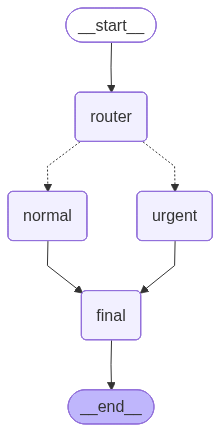

In [20]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [25]:
# ==========================================
# 4. 测试两种情况
# ==========================================
print("=== 测试 1: 普通请求 ===")
result1 = graph.invoke({"user_input": "帮我查一下订单123", "history": []})
print("最终回复:", result1["final_response"])

print("\n=== 测试 2: 紧急请求 ===")
result2 = graph.invoke({"user_input": "紧急！我的账户被盗了！", "history": []})
print("最终回复:", result2["final_response"])

=== 测试 1: 普通请求 ===
[Router Handler] 正在处理: 帮我查一下订单123
最终回复: 未检测到紧急需求，正常流程处理

=== 测试 2: 紧急请求 ===
[Router Handler] 正在处理: 紧急！我的账户被盗了！
[Urgent Handler] ⚠️ 检测到紧急请求！
最终回复: 🚨 紧急通道已开启！正在优先处理您的请求。


resume和graph参数在后续的课程中再详细介绍，因为主要是在HITL和使用到subgraph子图的场景下使用这两个参数。